## Motivation

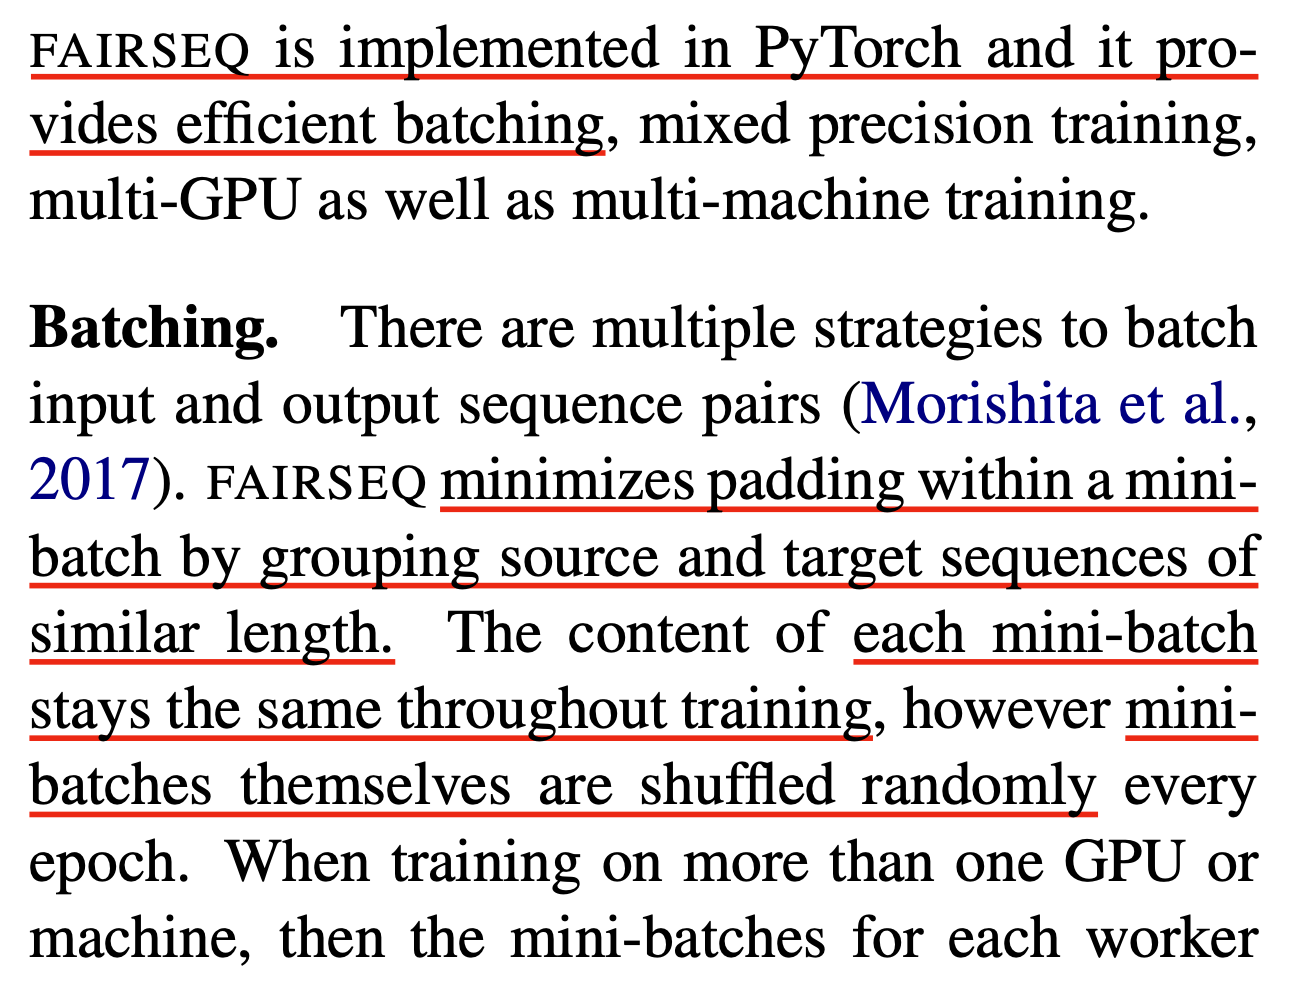

In [15]:
from IPython.display import Image
Image(filename='./assets/fairseq_bbs.png', width=500)

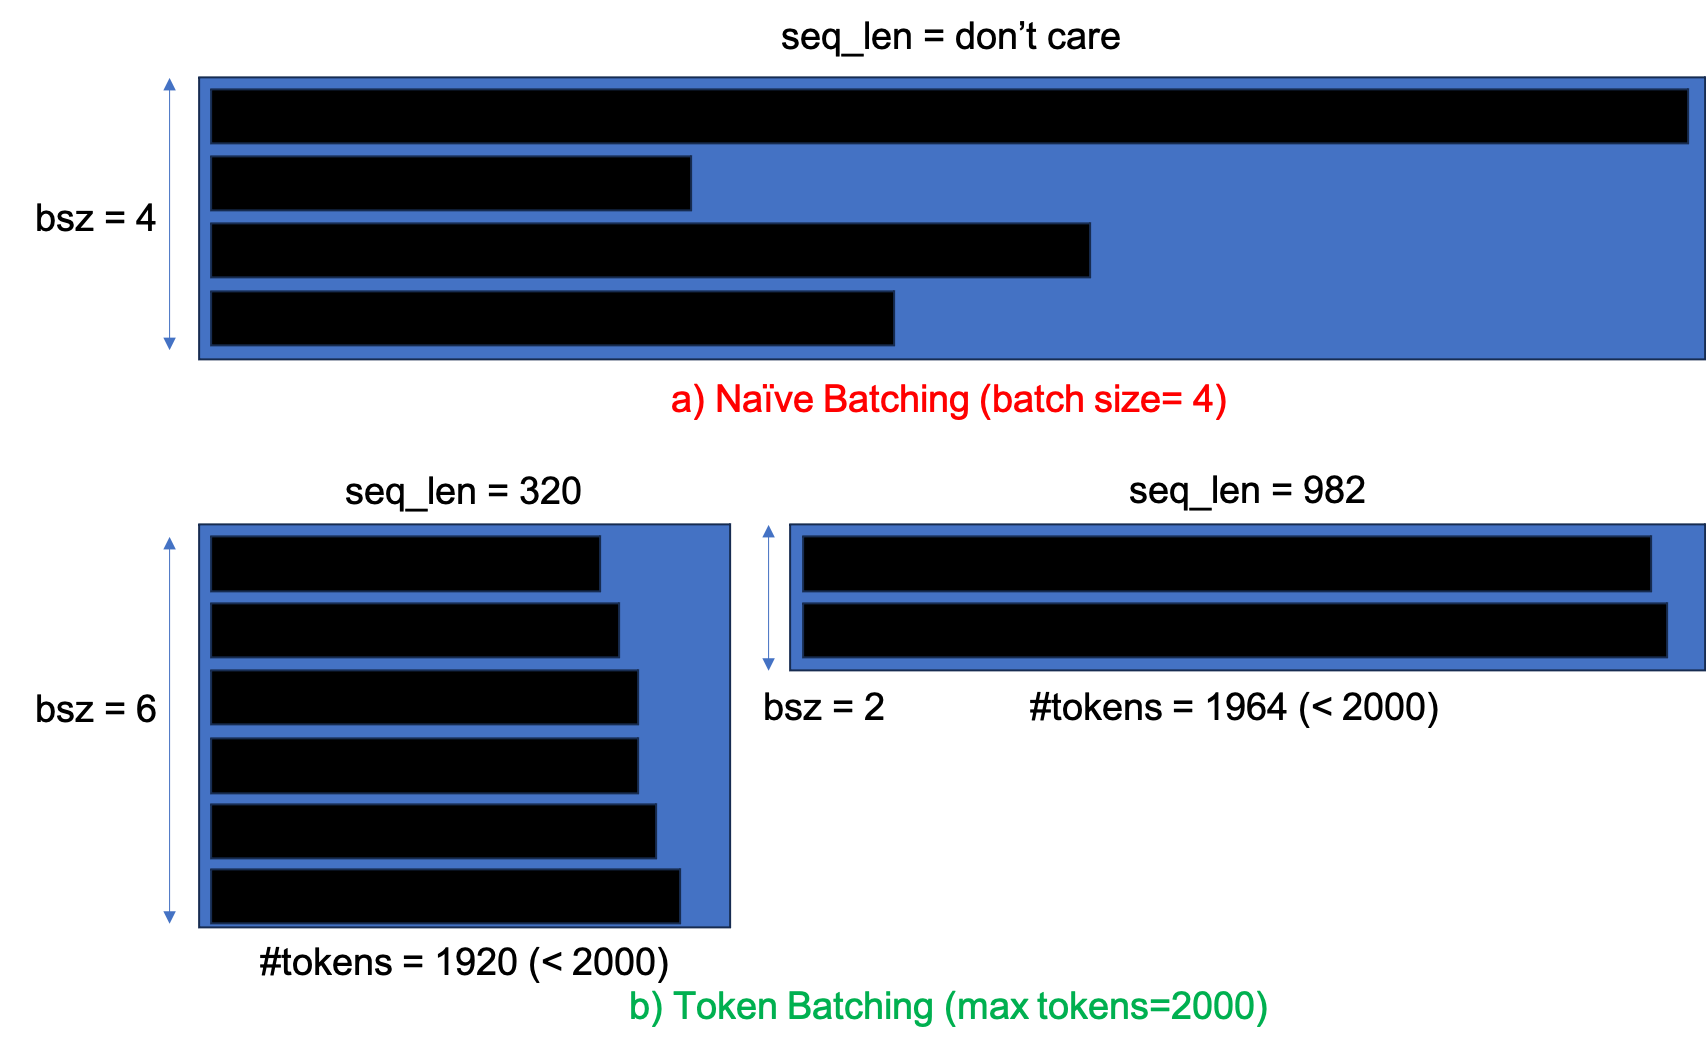

In [12]:
Image(filename='./assets/token_batching_example.png')

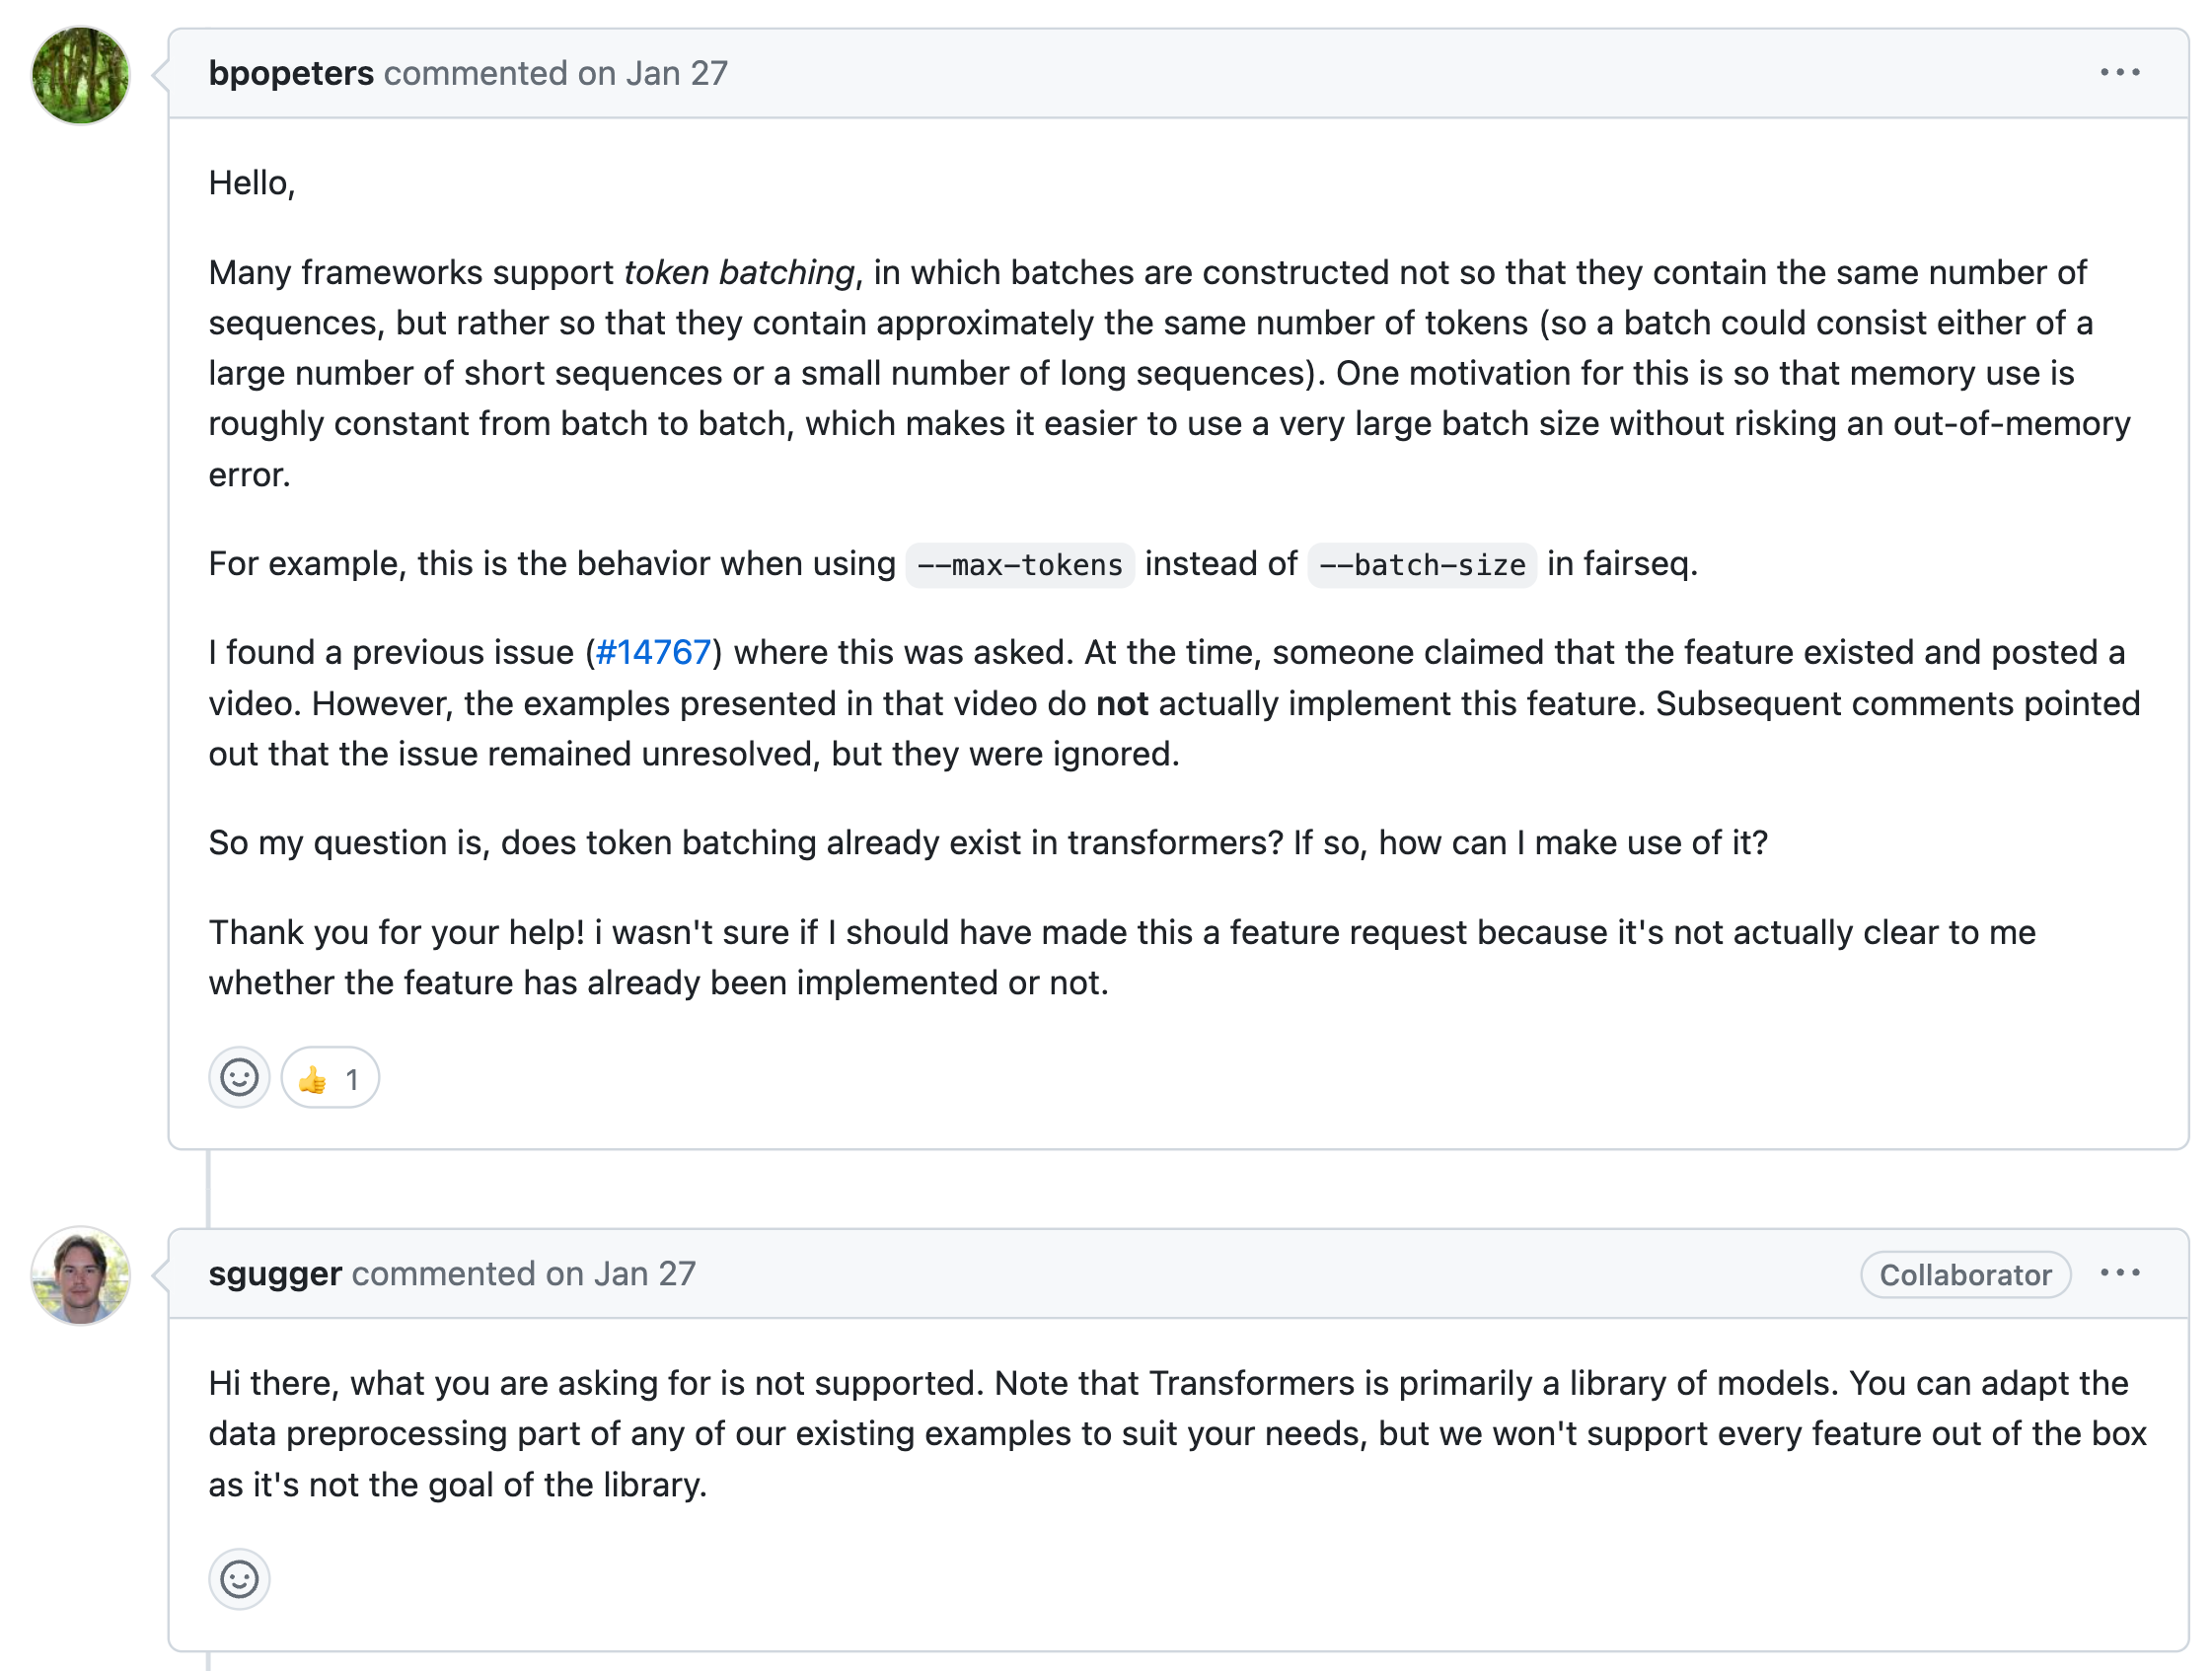

In [13]:
Image(filename='./assets/huggingface_transformers_issue_token_batching.png')

## Create Random Dataset

In [14]:
import random
import numpy as np

from typing import Optional, Tuple, List
try:
    from collections.abc import Iterable
except ImportError:
    from collections import Iterable

import torch
import torch.distributed as dist
from torch.utils.data import Dataset, DataLoader, Sampler, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler

from transformers.file_utils import cached_property
from transformers.trainer_pt_utils import SequentialDistributedSampler, ShardSampler

from fairseq.data.data_utils import batch_by_size

'''
batch_by_size source is from 
https://github.com/facebookresearch/fairseq/blob/main/fairseq/tasks/fairseq_task.py#L286-L306
https://github.com/facebookresearch/fairseq/blob/main/fairseq/data/audio/raw_audio_dataset.py#L190-L211
https://github.com/facebookresearch/fairseq/blob/main/fairseq/data/fairseq_dataset.py#L104-L153

https://github.com/facebookresearch/fairseq/blob/main/fairseq/data/data_utils.py
https://github.com/facebookresearch/fairseq/blob/main/fairseq/data/data_utils_fast.pyx


it is quite annoying to install cython extention, 
so it looks better to install fairseq

git clone https://github.com/facebookresearch/fairseq &&\
cd fairseq &&\
pip install -e . ## i recommend you to implement editable installation
'''


def _reset_seeds(seed=1234):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [16]:
class RandomDataset(Dataset):
    def __init__(self, num_data=100000, seed=2023):
        _reset_seeds(seed)
        self.src_lens = list(np.random.randint(60,2048,num_data))
#         print('seq_lens list from numpy random: {}'.format(self.src_lens))
        self.samples = [np.random.rand(src_len) for src_len in self.src_lens]
        self.max_target_length = 4096

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.src_lens[idx]

In [19]:
class RandomDatasetWithDynamicSampler(RandomDataset):
    def __init__(self, num_data=100000, seed=2023):
        super().__init__(num_data, seed)

    def make_sortish_sampler(self, batch_size, distributed=False, shuffle=False, **kwargs):
        if distributed:
            return DistributedSortishSampler(self, batch_size, shuffle=shuffle, **kwargs)
        else:
            return SortishSampler(self.src_lens, batch_size, shuffle=shuffle)

    def make_dynamic_sampler(self, max_tokens_per_batch=1024, **kwargs):
        sorted_indices = list(self.make_sortish_sampler(max_tokens_per_batch, shuffle=False))

        def num_tokens_fn(i):
            return min(self.src_lens[i], self.max_target_length)

        # call fairseq cython function
        batch_sampler: List[List[int]] = batch_by_size(
            sorted_indices,
            num_tokens_fn=num_tokens_fn,
            num_tokens_vec=None,
            max_tokens=max_tokens_per_batch,
            max_sentences=None, # it means batch size
#             required_batch_size_multiple=64,
            required_batch_size_multiple=1,
            fixed_shapes=None,
        )
        """
        Yield mini-batches of indices bucketed by size. Batches may contain
        sequences of different lengths.

        Args:
            indices (List[int]): ordered list of dataset indices
            num_tokens_fn (callable): function that returns the number of tokens at
                a given index
            num_tokens_vec (List[int], optional): precomputed vector of the number
                of tokens for each index in indices (to enable faster batch generation)
            max_tokens (int, optional): max number of tokens in each batch
                (default: None).
            max_sentences (int, optional): max number of sentences in each
                batch (default: None).
            required_batch_size_multiple (int, optional): require batch size to
                be less than N or a multiple of N (default: 1).
            fixed_shapes (List[Tuple[int, int]], optional): if given, batches will
                only be created with the given shapes. *max_sentences* and
                *required_batch_size_multiple* will be ignored (default: None).
        """
        shuffled_batches = [batch_sampler[i] for i in np.random.permutation(range(len(batch_sampler)))]
        
        # move the largest batch to the front to OOM quickly (uses an approximation for padding)
        approximate_toks_per_batch = [max(self.src_lens[i] for i in batch) * len(batch) for batch in shuffled_batches]
        largest_batch_idx = np.argmax(approximate_toks_per_batch)
        shuffled_batches[0], shuffled_batches[largest_batch_idx] = (
            shuffled_batches[largest_batch_idx],
            shuffled_batches[0],
        )
        
        return shuffled_batches

In [20]:
'''
fairseq batch_by_size (bbs) -> to huggingface style porting is from 
https://github.com/huggingface/transformers/blob/main/examples/research_projects/seq2seq-distillation/finetune.py#L267C37-L267C57
https://github.com/huggingface/transformers/blob/main/examples/research_projects/seq2seq-distillation/utils.py#L160

someone can implement more precisely and wrap huggingface dataset
'''

def sortish_sampler_indices(
    data: List, 
    bs: int, 
    shuffle=True
) -> np.array:
    "Go through the text data by order of src length with a bit of randomness. From fastai repo."
    if not shuffle:
        return np.argsort(np.array(data) * -1)

    def key_fn(i):
        return data[i]

    idxs = np.random.permutation(len(data))
    sz = bs * 50
    ck_idx = [idxs[i : i + sz] for i in range(0, len(idxs), sz)]
    sort_idx = np.concatenate([sorted(s, key=key_fn, reverse=True) for s in ck_idx])
    sz = bs
    ck_idx = [sort_idx[i : i + sz] for i in range(0, len(sort_idx), sz)]
    max_ck = np.argmax([key_fn(ck[0]) for ck in ck_idx])  # find the chunk with the largest key,
    ck_idx[0], ck_idx[max_ck] = ck_idx[max_ck], ck_idx[0]  # then make sure it goes first.
    sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([], dtype=int)
    sort_idx = np.concatenate((ck_idx[0], sort_idx))
    return sort_idx

class SortishSampler(Sampler):
    "Go through the text data by order of src length with a bit of randomness. From fastai repo."

    def __init__(
        self, 
        data, 
        batch_size, 
        shuffle=True
    ):
        self.data, self.bs, self.shuffle = data, batch_size, shuffle

    def __len__(self) -> int:
        return len(self.data)

    def __iter__(self):
        return iter(sortish_sampler_indices(self.data, self.bs, shuffle=self.shuffle))

class DistributedSortishSampler(Sampler):
    """Copied from torch DistributedSampler"""
    """
    https://pytorch.org/docs/stable/data.html#torch.utils.data.distributed.DistributedSampler
    
    Args: 
        dataset – Dataset used for sampling.

        num_replicas (int, optional) – Number of processes participating in distributed training. 
        By default, world_size is retrieved from the current distributed group.

        rank (int, optional) – Rank of the current process within num_replicas. 
        By default, rank is retrieved from the current distributed group.

        shuffle (bool, optional) – If True (default), sampler will shuffle the indices.

        seed (int, optional) – random seed used to shuffle the sampler if shuffle=True. 
        This number should be identical across all processes in the distributed group. 
        Default: 0.

        drop_last (bool, optional) – if True, then the sampler will drop the tail of the data 
        to make it evenly divisible across the number of replicas. 
        If False, the sampler will add extra indices to make the data evenly divisible across the replicas. 
        Default: False.
    """
    def __init__(
        self, 
        dataset, 
        batch_size, 
        num_replicas=None, 
        rank=None, 
        add_extra_examples=True, 
        shuffle=True
    ):
        if num_replicas is None:
            if not dist.is_available():
                raise RuntimeError("Requires distributed package to be available")
            num_replicas = dist.get_world_size()
        if rank is None:
            if not dist.is_available():
                raise RuntimeError("Requires distributed package to be available")
            rank = dist.get_rank()
        self.dataset = dataset
        self.num_replicas = num_replicas
        self.rank = rank
        self.epoch = 0
        if add_extra_examples:
            self.num_samples = int(math.ceil(len(self.dataset) * 1.0 / self.num_replicas))
            self.total_size = self.num_samples * self.num_replicas
        else:
            self.total_size = len(dataset)
            self.num_samples = len(self.available_indices)
        self.batch_size = batch_size
        self.add_extra_examples = add_extra_examples
        self.shuffle = shuffle

    def __iter__(self) -> Iterable:
        g = torch.Generator()
        g.manual_seed(self.epoch)

        sortish_data = [self.dataset.src_lens[i] for i in self.available_indices]
        sortish_indices = sortish_sampler_indices(sortish_data, self.batch_size, shuffle=self.shuffle)
        indices = [self.available_indices[i] for i in sortish_indices]
        assert len(indices) == self.num_samples
        return iter(indices)

    @cached_property
    def available_indices(self) -> np.array:
        indices = list(range(len(self.dataset)))
        # add extra samples to make it evenly divisible
        indices += indices[: (self.total_size - len(indices))]
        assert len(indices) == self.total_size
        # subsample
        available_indices = indices[self.rank : self.total_size : self.num_replicas]
        return available_indices

    def __len__(self):
        return self.num_samples

    def set_epoch(self, epoch):
        self.epoch = epoch

In [21]:
def collator(batch):
    sample_list = []
    seq_len_list = []
    for (sample, seq_len) in batch:
        sample_list.append(torch.FloatTensor(sample))
        seq_len_list.append(seq_len)
    max_len = max(seq_len_list)
    for i, sample in enumerate(sample_list):
        diff = max_len-seq_len_list[i]
        if diff!=0:
            sample_list[i] = torch.cat((sample, torch.zeros(diff)), dim=0)
        
    return torch.stack(sample_list, dim=0), seq_len_list

## sequential sampler

In [22]:
random_dataset = RandomDataset()
data_loader = DataLoader(
    random_dataset, 
    batch_size=128, 
    shuffle=False, 
    sampler=SequentialSampler(random_dataset),
    batch_sampler=None, # batch sampler and sampler is not compatible
    num_workers=0, 
    collate_fn=collator,
    pin_memory=False, 
    drop_last=False, 
)

print("total number of iteration: {}\n".format(len(data_loader)))
for x in iter(data_loader):
    print("bsz : {}, total tokens: {}, total tokens w/o padding: {}, min/max seq_lens in batch: {}, padding: {:.2f}%".format(
            x[0].size(), 
            x[0].size(0)*x[0].size(1), 
            sum(x[1]),
            (max(x[1]),min(x[1])),
            (x[0].size(0)*x[0].size(1) - sum(x[1]))/(x[0].size(0)*x[0].size(1))*100,
        )
    )

total number of iteration: 782

bsz : torch.Size([128, 2033]), total tokens: 260224, total tokens w/o padding: 131676, min/max seq_lens in batch: (2033, 99), padding: 49.40%
bsz : torch.Size([128, 2036]), total tokens: 260608, total tokens w/o padding: 131425, min/max seq_lens in batch: (2036, 89), padding: 49.57%
bsz : torch.Size([128, 2040]), total tokens: 261120, total tokens w/o padding: 145690, min/max seq_lens in batch: (2040, 61), padding: 44.21%
bsz : torch.Size([128, 2031]), total tokens: 259968, total tokens w/o padding: 142966, min/max seq_lens in batch: (2031, 81), padding: 45.01%
bsz : torch.Size([128, 2034]), total tokens: 260352, total tokens w/o padding: 139517, min/max seq_lens in batch: (2034, 63), padding: 46.41%
bsz : torch.Size([128, 2043]), total tokens: 261504, total tokens w/o padding: 145594, min/max seq_lens in batch: (2043, 104), padding: 44.32%
bsz : torch.Size([128, 2044]), total tokens: 261632, total tokens w/o padding: 125540, min/max seq_lens in batch: (

bsz : torch.Size([128, 2047]), total tokens: 262016, total tokens w/o padding: 141901, min/max seq_lens in batch: (2047, 97), padding: 45.84%
bsz : torch.Size([128, 2039]), total tokens: 260992, total tokens w/o padding: 132017, min/max seq_lens in batch: (2039, 67), padding: 49.42%
bsz : torch.Size([128, 2047]), total tokens: 262016, total tokens w/o padding: 130612, min/max seq_lens in batch: (2047, 86), padding: 50.15%
bsz : torch.Size([128, 2042]), total tokens: 261376, total tokens w/o padding: 147808, min/max seq_lens in batch: (2042, 142), padding: 43.45%
bsz : torch.Size([128, 2038]), total tokens: 260864, total tokens w/o padding: 133317, min/max seq_lens in batch: (2038, 65), padding: 48.89%
bsz : torch.Size([128, 2014]), total tokens: 257792, total tokens w/o padding: 134290, min/max seq_lens in batch: (2014, 69), padding: 47.91%
bsz : torch.Size([128, 2035]), total tokens: 260480, total tokens w/o padding: 136267, min/max seq_lens in batch: (2035, 105), padding: 47.69%
bsz 

bsz : torch.Size([128, 2038]), total tokens: 260864, total tokens w/o padding: 137063, min/max seq_lens in batch: (2038, 80), padding: 47.46%
bsz : torch.Size([128, 2044]), total tokens: 261632, total tokens w/o padding: 133763, min/max seq_lens in batch: (2044, 90), padding: 48.87%
bsz : torch.Size([128, 2024]), total tokens: 259072, total tokens w/o padding: 125080, min/max seq_lens in batch: (2024, 62), padding: 51.72%
bsz : torch.Size([128, 2046]), total tokens: 261888, total tokens w/o padding: 130741, min/max seq_lens in batch: (2046, 61), padding: 50.08%
bsz : torch.Size([128, 2026]), total tokens: 259328, total tokens w/o padding: 140336, min/max seq_lens in batch: (2026, 83), padding: 45.88%
bsz : torch.Size([128, 2047]), total tokens: 262016, total tokens w/o padding: 144679, min/max seq_lens in batch: (2047, 122), padding: 44.78%
bsz : torch.Size([128, 2035]), total tokens: 260480, total tokens w/o padding: 128819, min/max seq_lens in batch: (2035, 82), padding: 50.55%
bsz :

bsz : torch.Size([128, 2044]), total tokens: 261632, total tokens w/o padding: 139812, min/max seq_lens in batch: (2044, 80), padding: 46.56%
bsz : torch.Size([128, 2046]), total tokens: 261888, total tokens w/o padding: 133347, min/max seq_lens in batch: (2046, 78), padding: 49.08%
bsz : torch.Size([128, 2010]), total tokens: 257280, total tokens w/o padding: 132040, min/max seq_lens in batch: (2010, 62), padding: 48.68%
bsz : torch.Size([128, 1983]), total tokens: 253824, total tokens w/o padding: 135084, min/max seq_lens in batch: (1983, 61), padding: 46.78%
bsz : torch.Size([128, 2005]), total tokens: 256640, total tokens w/o padding: 135643, min/max seq_lens in batch: (2005, 72), padding: 47.15%
bsz : torch.Size([128, 2047]), total tokens: 262016, total tokens w/o padding: 138784, min/max seq_lens in batch: (2047, 62), padding: 47.03%
bsz : torch.Size([128, 2028]), total tokens: 259584, total tokens w/o padding: 138488, min/max seq_lens in batch: (2028, 62), padding: 46.65%
bsz : 

bsz : torch.Size([128, 2040]), total tokens: 261120, total tokens w/o padding: 129059, min/max seq_lens in batch: (2040, 90), padding: 50.57%
bsz : torch.Size([128, 2028]), total tokens: 259584, total tokens w/o padding: 129460, min/max seq_lens in batch: (2028, 61), padding: 50.13%
bsz : torch.Size([128, 2029]), total tokens: 259712, total tokens w/o padding: 136564, min/max seq_lens in batch: (2029, 84), padding: 47.42%
bsz : torch.Size([128, 2046]), total tokens: 261888, total tokens w/o padding: 136433, min/max seq_lens in batch: (2046, 70), padding: 47.90%
bsz : torch.Size([128, 2034]), total tokens: 260352, total tokens w/o padding: 125228, min/max seq_lens in batch: (2034, 62), padding: 51.90%
bsz : torch.Size([128, 2042]), total tokens: 261376, total tokens w/o padding: 125353, min/max seq_lens in batch: (2042, 70), padding: 52.04%
bsz : torch.Size([128, 2047]), total tokens: 262016, total tokens w/o padding: 124242, min/max seq_lens in batch: (2047, 65), padding: 52.58%
bsz : 

bsz : torch.Size([128, 2039]), total tokens: 260992, total tokens w/o padding: 147201, min/max seq_lens in batch: (2039, 67), padding: 43.60%
bsz : torch.Size([128, 2045]), total tokens: 261760, total tokens w/o padding: 125595, min/max seq_lens in batch: (2045, 95), padding: 52.02%
bsz : torch.Size([128, 2010]), total tokens: 257280, total tokens w/o padding: 140495, min/max seq_lens in batch: (2010, 62), padding: 45.39%
bsz : torch.Size([128, 2045]), total tokens: 261760, total tokens w/o padding: 136940, min/max seq_lens in batch: (2045, 65), padding: 47.68%
bsz : torch.Size([128, 2047]), total tokens: 262016, total tokens w/o padding: 138570, min/max seq_lens in batch: (2047, 113), padding: 47.11%
bsz : torch.Size([128, 2044]), total tokens: 261632, total tokens w/o padding: 135128, min/max seq_lens in batch: (2044, 78), padding: 48.35%
bsz : torch.Size([128, 2045]), total tokens: 261760, total tokens w/o padding: 144183, min/max seq_lens in batch: (2045, 65), padding: 44.92%
bsz :

bsz : torch.Size([128, 2031]), total tokens: 259968, total tokens w/o padding: 132949, min/max seq_lens in batch: (2031, 61), padding: 48.86%
bsz : torch.Size([128, 2044]), total tokens: 261632, total tokens w/o padding: 138465, min/max seq_lens in batch: (2044, 79), padding: 47.08%
bsz : torch.Size([128, 2046]), total tokens: 261888, total tokens w/o padding: 127047, min/max seq_lens in batch: (2046, 69), padding: 51.49%
bsz : torch.Size([128, 2039]), total tokens: 260992, total tokens w/o padding: 127826, min/max seq_lens in batch: (2039, 62), padding: 51.02%
bsz : torch.Size([128, 2034]), total tokens: 260352, total tokens w/o padding: 128556, min/max seq_lens in batch: (2034, 64), padding: 50.62%
bsz : torch.Size([128, 1987]), total tokens: 254336, total tokens w/o padding: 131744, min/max seq_lens in batch: (1987, 87), padding: 48.20%
bsz : torch.Size([128, 2010]), total tokens: 257280, total tokens w/o padding: 127469, min/max seq_lens in batch: (2010, 76), padding: 50.46%
bsz : 

bsz : torch.Size([128, 2045]), total tokens: 261760, total tokens w/o padding: 135811, min/max seq_lens in batch: (2045, 63), padding: 48.12%
bsz : torch.Size([128, 2012]), total tokens: 257536, total tokens w/o padding: 138916, min/max seq_lens in batch: (2012, 73), padding: 46.06%
bsz : torch.Size([128, 2015]), total tokens: 257920, total tokens w/o padding: 129872, min/max seq_lens in batch: (2015, 62), padding: 49.65%
bsz : torch.Size([128, 2041]), total tokens: 261248, total tokens w/o padding: 139821, min/max seq_lens in batch: (2041, 89), padding: 46.48%
bsz : torch.Size([128, 2035]), total tokens: 260480, total tokens w/o padding: 142618, min/max seq_lens in batch: (2035, 61), padding: 45.25%
bsz : torch.Size([128, 2042]), total tokens: 261376, total tokens w/o padding: 131810, min/max seq_lens in batch: (2042, 71), padding: 49.57%
bsz : torch.Size([128, 2015]), total tokens: 257920, total tokens w/o padding: 147355, min/max seq_lens in batch: (2015, 69), padding: 42.87%
bsz : 

bsz : torch.Size([128, 2019]), total tokens: 258432, total tokens w/o padding: 133880, min/max seq_lens in batch: (2019, 62), padding: 48.20%
bsz : torch.Size([128, 2037]), total tokens: 260736, total tokens w/o padding: 143928, min/max seq_lens in batch: (2037, 60), padding: 44.80%
bsz : torch.Size([128, 2042]), total tokens: 261376, total tokens w/o padding: 133941, min/max seq_lens in batch: (2042, 62), padding: 48.76%
bsz : torch.Size([128, 2037]), total tokens: 260736, total tokens w/o padding: 135710, min/max seq_lens in batch: (2037, 63), padding: 47.95%
bsz : torch.Size([128, 2030]), total tokens: 259840, total tokens w/o padding: 134883, min/max seq_lens in batch: (2030, 81), padding: 48.09%
bsz : torch.Size([128, 2042]), total tokens: 261376, total tokens w/o padding: 136111, min/max seq_lens in batch: (2042, 83), padding: 47.93%
bsz : torch.Size([128, 2039]), total tokens: 260992, total tokens w/o padding: 135765, min/max seq_lens in batch: (2039, 61), padding: 47.98%
bsz : 

bsz : torch.Size([128, 1996]), total tokens: 255488, total tokens w/o padding: 129036, min/max seq_lens in batch: (1996, 64), padding: 49.49%
bsz : torch.Size([128, 2031]), total tokens: 259968, total tokens w/o padding: 127455, min/max seq_lens in batch: (2031, 76), padding: 50.97%
bsz : torch.Size([128, 2011]), total tokens: 257408, total tokens w/o padding: 141299, min/max seq_lens in batch: (2011, 68), padding: 45.11%
bsz : torch.Size([128, 2044]), total tokens: 261632, total tokens w/o padding: 139649, min/max seq_lens in batch: (2044, 72), padding: 46.62%
bsz : torch.Size([128, 2046]), total tokens: 261888, total tokens w/o padding: 134418, min/max seq_lens in batch: (2046, 73), padding: 48.67%
bsz : torch.Size([128, 2045]), total tokens: 261760, total tokens w/o padding: 141358, min/max seq_lens in batch: (2045, 66), padding: 46.00%
bsz : torch.Size([128, 2047]), total tokens: 262016, total tokens w/o padding: 121715, min/max seq_lens in batch: (2047, 77), padding: 53.55%
bsz : 

bsz : torch.Size([128, 2007]), total tokens: 256896, total tokens w/o padding: 135416, min/max seq_lens in batch: (2007, 67), padding: 47.29%
bsz : torch.Size([128, 2029]), total tokens: 259712, total tokens w/o padding: 123255, min/max seq_lens in batch: (2029, 94), padding: 52.54%
bsz : torch.Size([128, 2030]), total tokens: 259840, total tokens w/o padding: 129259, min/max seq_lens in batch: (2030, 66), padding: 50.25%
bsz : torch.Size([128, 2025]), total tokens: 259200, total tokens w/o padding: 123532, min/max seq_lens in batch: (2025, 64), padding: 52.34%
bsz : torch.Size([128, 2042]), total tokens: 261376, total tokens w/o padding: 131300, min/max seq_lens in batch: (2042, 63), padding: 49.77%
bsz : torch.Size([128, 2045]), total tokens: 261760, total tokens w/o padding: 139948, min/max seq_lens in batch: (2045, 71), padding: 46.54%
bsz : torch.Size([128, 2032]), total tokens: 260096, total tokens w/o padding: 132867, min/max seq_lens in batch: (2032, 66), padding: 48.92%
bsz : 

## random sampler

In [23]:
random_dataset = RandomDataset()
data_loader = DataLoader(
    random_dataset, 
    batch_size=128, 
    shuffle=False, 
    sampler=RandomSampler(random_dataset),
    batch_sampler=None, # batch sampler and sampler is not compatible
    num_workers=0, 
    collate_fn=collator,
    pin_memory=False, 
    drop_last=False, 
)

print("total number of iteration: {}\n".format(len(data_loader)))
for x in iter(data_loader):
    print("bsz : {}, total tokens: {}, total tokens w/o padding: {}, min/max seq_lens in batch: {}, padding: {:.2f}%".format(
            x[0].size(), 
            x[0].size(0)*x[0].size(1), 
            sum(x[1]),
            (max(x[1]),min(x[1])),
            (x[0].size(0)*x[0].size(1) - sum(x[1]))/(x[0].size(0)*x[0].size(1))*100,
        )
    )

total number of iteration: 782

bsz : torch.Size([128, 2046]), total tokens: 261888, total tokens w/o padding: 132097, min/max seq_lens in batch: (2046, 87), padding: 49.56%
bsz : torch.Size([128, 2047]), total tokens: 262016, total tokens w/o padding: 126377, min/max seq_lens in batch: (2047, 73), padding: 51.77%
bsz : torch.Size([128, 2030]), total tokens: 259840, total tokens w/o padding: 141837, min/max seq_lens in batch: (2030, 87), padding: 45.41%
bsz : torch.Size([128, 2042]), total tokens: 261376, total tokens w/o padding: 131386, min/max seq_lens in batch: (2042, 67), padding: 49.73%
bsz : torch.Size([128, 2042]), total tokens: 261376, total tokens w/o padding: 138499, min/max seq_lens in batch: (2042, 116), padding: 47.01%
bsz : torch.Size([128, 2042]), total tokens: 261376, total tokens w/o padding: 135383, min/max seq_lens in batch: (2042, 63), padding: 48.20%
bsz : torch.Size([128, 2047]), total tokens: 262016, total tokens w/o padding: 131189, min/max seq_lens in batch: (

bsz : torch.Size([128, 2044]), total tokens: 261632, total tokens w/o padding: 140293, min/max seq_lens in batch: (2044, 60), padding: 46.38%
bsz : torch.Size([128, 2047]), total tokens: 262016, total tokens w/o padding: 131882, min/max seq_lens in batch: (2047, 95), padding: 49.67%
bsz : torch.Size([128, 2046]), total tokens: 261888, total tokens w/o padding: 128632, min/max seq_lens in batch: (2046, 70), padding: 50.88%
bsz : torch.Size([128, 2020]), total tokens: 258560, total tokens w/o padding: 146433, min/max seq_lens in batch: (2020, 68), padding: 43.37%
bsz : torch.Size([128, 2041]), total tokens: 261248, total tokens w/o padding: 129136, min/max seq_lens in batch: (2041, 66), padding: 50.57%
bsz : torch.Size([128, 2017]), total tokens: 258176, total tokens w/o padding: 136551, min/max seq_lens in batch: (2017, 66), padding: 47.11%
bsz : torch.Size([128, 2032]), total tokens: 260096, total tokens w/o padding: 129779, min/max seq_lens in batch: (2032, 77), padding: 50.10%
bsz : 

bsz : torch.Size([128, 2046]), total tokens: 261888, total tokens w/o padding: 139351, min/max seq_lens in batch: (2046, 60), padding: 46.79%
bsz : torch.Size([128, 2045]), total tokens: 261760, total tokens w/o padding: 131380, min/max seq_lens in batch: (2045, 103), padding: 49.81%
bsz : torch.Size([128, 2045]), total tokens: 261760, total tokens w/o padding: 129160, min/max seq_lens in batch: (2045, 73), padding: 50.66%
bsz : torch.Size([128, 2008]), total tokens: 257024, total tokens w/o padding: 125759, min/max seq_lens in batch: (2008, 67), padding: 51.07%
bsz : torch.Size([128, 2006]), total tokens: 256768, total tokens w/o padding: 127463, min/max seq_lens in batch: (2006, 75), padding: 50.36%
bsz : torch.Size([128, 2022]), total tokens: 258816, total tokens w/o padding: 140856, min/max seq_lens in batch: (2022, 79), padding: 45.58%
bsz : torch.Size([128, 2047]), total tokens: 262016, total tokens w/o padding: 137703, min/max seq_lens in batch: (2047, 69), padding: 47.44%
bsz :

bsz : torch.Size([128, 2043]), total tokens: 261504, total tokens w/o padding: 128056, min/max seq_lens in batch: (2043, 60), padding: 51.03%
bsz : torch.Size([128, 2030]), total tokens: 259840, total tokens w/o padding: 123365, min/max seq_lens in batch: (2030, 75), padding: 52.52%
bsz : torch.Size([128, 2046]), total tokens: 261888, total tokens w/o padding: 141900, min/max seq_lens in batch: (2046, 103), padding: 45.82%
bsz : torch.Size([128, 2025]), total tokens: 259200, total tokens w/o padding: 125136, min/max seq_lens in batch: (2025, 66), padding: 51.72%
bsz : torch.Size([128, 2025]), total tokens: 259200, total tokens w/o padding: 140264, min/max seq_lens in batch: (2025, 94), padding: 45.89%
bsz : torch.Size([128, 2033]), total tokens: 260224, total tokens w/o padding: 133537, min/max seq_lens in batch: (2033, 70), padding: 48.68%
bsz : torch.Size([128, 2036]), total tokens: 260608, total tokens w/o padding: 129084, min/max seq_lens in batch: (2036, 65), padding: 50.47%
bsz :

bsz : torch.Size([128, 2032]), total tokens: 260096, total tokens w/o padding: 141482, min/max seq_lens in batch: (2032, 79), padding: 45.60%
bsz : torch.Size([128, 2036]), total tokens: 260608, total tokens w/o padding: 130238, min/max seq_lens in batch: (2036, 126), padding: 50.03%
bsz : torch.Size([128, 2041]), total tokens: 261248, total tokens w/o padding: 143303, min/max seq_lens in batch: (2041, 69), padding: 45.15%
bsz : torch.Size([128, 2045]), total tokens: 261760, total tokens w/o padding: 129101, min/max seq_lens in batch: (2045, 60), padding: 50.68%
bsz : torch.Size([128, 2041]), total tokens: 261248, total tokens w/o padding: 133715, min/max seq_lens in batch: (2041, 95), padding: 48.82%
bsz : torch.Size([128, 2025]), total tokens: 259200, total tokens w/o padding: 151236, min/max seq_lens in batch: (2025, 87), padding: 41.65%
bsz : torch.Size([128, 2047]), total tokens: 262016, total tokens w/o padding: 135704, min/max seq_lens in batch: (2047, 67), padding: 48.21%
bsz :

bsz : torch.Size([128, 2025]), total tokens: 259200, total tokens w/o padding: 129267, min/max seq_lens in batch: (2025, 68), padding: 50.13%
bsz : torch.Size([128, 2031]), total tokens: 259968, total tokens w/o padding: 132341, min/max seq_lens in batch: (2031, 81), padding: 49.09%
bsz : torch.Size([128, 1991]), total tokens: 254848, total tokens w/o padding: 129374, min/max seq_lens in batch: (1991, 60), padding: 49.23%
bsz : torch.Size([128, 2038]), total tokens: 260864, total tokens w/o padding: 125137, min/max seq_lens in batch: (2038, 60), padding: 52.03%
bsz : torch.Size([128, 2040]), total tokens: 261120, total tokens w/o padding: 142417, min/max seq_lens in batch: (2040, 111), padding: 45.46%
bsz : torch.Size([128, 2015]), total tokens: 257920, total tokens w/o padding: 132432, min/max seq_lens in batch: (2015, 60), padding: 48.65%
bsz : torch.Size([128, 2036]), total tokens: 260608, total tokens w/o padding: 131767, min/max seq_lens in batch: (2036, 79), padding: 49.44%
bsz :

bsz : torch.Size([128, 2029]), total tokens: 259712, total tokens w/o padding: 129744, min/max seq_lens in batch: (2029, 80), padding: 50.04%
bsz : torch.Size([128, 2046]), total tokens: 261888, total tokens w/o padding: 134182, min/max seq_lens in batch: (2046, 63), padding: 48.76%
bsz : torch.Size([128, 2045]), total tokens: 261760, total tokens w/o padding: 146801, min/max seq_lens in batch: (2045, 62), padding: 43.92%
bsz : torch.Size([128, 2041]), total tokens: 261248, total tokens w/o padding: 131305, min/max seq_lens in batch: (2041, 76), padding: 49.74%
bsz : torch.Size([128, 2013]), total tokens: 257664, total tokens w/o padding: 132465, min/max seq_lens in batch: (2013, 110), padding: 48.59%
bsz : torch.Size([128, 2047]), total tokens: 262016, total tokens w/o padding: 122298, min/max seq_lens in batch: (2047, 64), padding: 53.32%
bsz : torch.Size([128, 2033]), total tokens: 260224, total tokens w/o padding: 122406, min/max seq_lens in batch: (2033, 71), padding: 52.96%
bsz :

bsz : torch.Size([128, 2042]), total tokens: 261376, total tokens w/o padding: 133382, min/max seq_lens in batch: (2042, 66), padding: 48.97%
bsz : torch.Size([128, 2013]), total tokens: 257664, total tokens w/o padding: 130452, min/max seq_lens in batch: (2013, 62), padding: 49.37%
bsz : torch.Size([128, 2047]), total tokens: 262016, total tokens w/o padding: 135332, min/max seq_lens in batch: (2047, 83), padding: 48.35%
bsz : torch.Size([128, 2037]), total tokens: 260736, total tokens w/o padding: 135218, min/max seq_lens in batch: (2037, 69), padding: 48.14%
bsz : torch.Size([128, 2033]), total tokens: 260224, total tokens w/o padding: 139236, min/max seq_lens in batch: (2033, 73), padding: 46.49%
bsz : torch.Size([128, 2011]), total tokens: 257408, total tokens w/o padding: 137611, min/max seq_lens in batch: (2011, 60), padding: 46.54%
bsz : torch.Size([128, 2044]), total tokens: 261632, total tokens w/o padding: 127279, min/max seq_lens in batch: (2044, 86), padding: 51.35%
bsz : 

bsz : torch.Size([128, 2024]), total tokens: 259072, total tokens w/o padding: 133527, min/max seq_lens in batch: (2024, 61), padding: 48.46%
bsz : torch.Size([128, 2040]), total tokens: 261120, total tokens w/o padding: 132447, min/max seq_lens in batch: (2040, 79), padding: 49.28%
bsz : torch.Size([128, 2030]), total tokens: 259840, total tokens w/o padding: 140392, min/max seq_lens in batch: (2030, 72), padding: 45.97%
bsz : torch.Size([128, 2043]), total tokens: 261504, total tokens w/o padding: 131805, min/max seq_lens in batch: (2043, 68), padding: 49.60%
bsz : torch.Size([128, 2028]), total tokens: 259584, total tokens w/o padding: 131003, min/max seq_lens in batch: (2028, 82), padding: 49.53%
bsz : torch.Size([128, 1979]), total tokens: 253312, total tokens w/o padding: 136318, min/max seq_lens in batch: (1979, 73), padding: 46.19%
bsz : torch.Size([128, 2027]), total tokens: 259456, total tokens w/o padding: 127482, min/max seq_lens in batch: (2027, 70), padding: 50.87%
bsz : 

bsz : torch.Size([128, 2039]), total tokens: 260992, total tokens w/o padding: 141339, min/max seq_lens in batch: (2039, 85), padding: 45.85%
bsz : torch.Size([128, 2035]), total tokens: 260480, total tokens w/o padding: 133942, min/max seq_lens in batch: (2035, 67), padding: 48.58%
bsz : torch.Size([128, 2028]), total tokens: 259584, total tokens w/o padding: 128134, min/max seq_lens in batch: (2028, 61), padding: 50.64%
bsz : torch.Size([128, 2041]), total tokens: 261248, total tokens w/o padding: 140477, min/max seq_lens in batch: (2041, 76), padding: 46.23%
bsz : torch.Size([128, 2046]), total tokens: 261888, total tokens w/o padding: 130457, min/max seq_lens in batch: (2046, 94), padding: 50.19%
bsz : torch.Size([128, 2042]), total tokens: 261376, total tokens w/o padding: 124437, min/max seq_lens in batch: (2042, 76), padding: 52.39%
bsz : torch.Size([128, 2045]), total tokens: 261760, total tokens w/o padding: 129844, min/max seq_lens in batch: (2045, 61), padding: 50.40%
bsz : 

bsz : torch.Size([128, 2020]), total tokens: 258560, total tokens w/o padding: 135757, min/max seq_lens in batch: (2020, 60), padding: 47.49%
bsz : torch.Size([128, 2019]), total tokens: 258432, total tokens w/o padding: 127073, min/max seq_lens in batch: (2019, 110), padding: 50.83%
bsz : torch.Size([128, 2036]), total tokens: 260608, total tokens w/o padding: 133561, min/max seq_lens in batch: (2036, 90), padding: 48.75%
bsz : torch.Size([128, 2045]), total tokens: 261760, total tokens w/o padding: 126803, min/max seq_lens in batch: (2045, 68), padding: 51.56%
bsz : torch.Size([128, 2029]), total tokens: 259712, total tokens w/o padding: 128383, min/max seq_lens in batch: (2029, 70), padding: 50.57%
bsz : torch.Size([128, 2014]), total tokens: 257792, total tokens w/o padding: 142849, min/max seq_lens in batch: (2014, 61), padding: 44.59%
bsz : torch.Size([128, 2031]), total tokens: 259968, total tokens w/o padding: 144655, min/max seq_lens in batch: (2031, 60), padding: 44.36%
bsz :

bsz : torch.Size([32, 1977]), total tokens: 63264, total tokens w/o padding: 37537, min/max seq_lens in batch: (1977, 180), padding: 40.67%


## dynamic batching

In [24]:
random_dataset = RandomDatasetWithDynamicSampler()
dynamic_batch_sampler = random_dataset.make_dynamic_sampler(max_tokens_per_batch=250000)
data_loader = DataLoader(
    random_dataset, 
    batch_size=1, # be careful of setting batch size larger than 1, it is not compatible with batch sampler
    shuffle=False, # be careful of setting shuffle True, it is not compatible with batch sampler
    sampler=None,
    batch_sampler=dynamic_batch_sampler, # batch sampler and sampler is not compatible
    num_workers=0, 
    collate_fn=collator,
    pin_memory=False, 
    drop_last=False, # be careful of setting drop_last True, it is not compatible with batch sampler
)


print("total number of iteration: {}\n".format(len(data_loader)))
for x in iter(data_loader):
    print("bsz : {}, total tokens: {}, total tokens w/o padding: {}, min/max seq_lens in batch: {}, padding: {:.2f}%".format(
            x[0].size(), 
            x[0].size(0)*x[0].size(1), 
            sum(x[1]),
            (max(x[1]),min(x[1])),
            (x[0].size(0)*x[0].size(1) - sum(x[1]))/(x[0].size(0)*x[0].size(1))*100,
        )
    )

total number of iteration: 424

bsz : torch.Size([500, 500]), total tokens: 250000, total tokens w/o padding: 247473, min/max seq_lens in batch: (500, 490), padding: 1.01%
bsz : torch.Size([185, 1350]), total tokens: 249750, total tokens w/o padding: 249448, min/max seq_lens in batch: (1350, 1346), padding: 0.12%
bsz : torch.Size([213, 1171]), total tokens: 249423, total tokens w/o padding: 248969, min/max seq_lens in batch: (1171, 1166), padding: 0.18%
bsz : torch.Size([165, 1508]), total tokens: 248820, total tokens w/o padding: 248596, min/max seq_lens in batch: (1508, 1505), padding: 0.09%
bsz : torch.Size([397, 629]), total tokens: 249713, total tokens w/o padding: 247981, min/max seq_lens in batch: (629, 621), padding: 0.69%
bsz : torch.Size([219, 1140]), total tokens: 249660, total tokens w/o padding: 249289, min/max seq_lens in batch: (1140, 1136), padding: 0.15%
bsz : torch.Size([146, 1701]), total tokens: 248346, total tokens w/o padding: 248202, min/max seq_lens in batch: (1

bsz : torch.Size([195, 1280]), total tokens: 249600, total tokens w/o padding: 249144, min/max seq_lens in batch: (1280, 1276), padding: 0.18%
bsz : torch.Size([257, 972]), total tokens: 249804, total tokens w/o padding: 249108, min/max seq_lens in batch: (972, 967), padding: 0.28%
bsz : torch.Size([218, 1144]), total tokens: 249392, total tokens w/o padding: 248974, min/max seq_lens in batch: (1144, 1140), padding: 0.17%
bsz : torch.Size([130, 1916]), total tokens: 249080, total tokens w/o padding: 248918, min/max seq_lens in batch: (1916, 1914), padding: 0.07%
bsz : torch.Size([965, 259]), total tokens: 249935, total tokens w/o padding: 240998, min/max seq_lens in batch: (259, 241), padding: 3.58%
bsz : torch.Size([197, 1264]), total tokens: 249008, total tokens w/o padding: 248721, min/max seq_lens in batch: (1264, 1261), padding: 0.12%
bsz : torch.Size([204, 1224]), total tokens: 249696, total tokens w/o padding: 249332, min/max seq_lens in batch: (1224, 1220), padding: 0.15%
bsz :

bsz : torch.Size([1262, 198]), total tokens: 249876, total tokens w/o padding: 233470, min/max seq_lens in batch: (198, 172), padding: 6.57%
bsz : torch.Size([135, 1850]), total tokens: 249750, total tokens w/o padding: 249595, min/max seq_lens in batch: (1850, 1848), padding: 0.06%
bsz : torch.Size([145, 1713]), total tokens: 248385, total tokens w/o padding: 248173, min/max seq_lens in batch: (1713, 1710), padding: 0.09%
bsz : torch.Size([202, 1232]), total tokens: 248864, total tokens w/o padding: 248543, min/max seq_lens in batch: (1232, 1228), padding: 0.13%
bsz : torch.Size([234, 1065]), total tokens: 249210, total tokens w/o padding: 248516, min/max seq_lens in batch: (1065, 1059), padding: 0.28%
bsz : torch.Size([228, 1095]), total tokens: 249660, total tokens w/o padding: 249171, min/max seq_lens in batch: (1095, 1091), padding: 0.20%
bsz : torch.Size([241, 1036]), total tokens: 249676, total tokens w/o padding: 248997, min/max seq_lens in batch: (1036, 1031), padding: 0.27%
b

bsz : torch.Size([519, 481]), total tokens: 249639, total tokens w/o padding: 246576, min/max seq_lens in batch: (481, 470), padding: 1.23%
bsz : torch.Size([130, 1918]), total tokens: 249340, total tokens w/o padding: 249257, min/max seq_lens in batch: (1918, 1916), padding: 0.03%
bsz : torch.Size([133, 1879]), total tokens: 249907, total tokens w/o padding: 249709, min/max seq_lens in batch: (1879, 1876), padding: 0.08%
bsz : torch.Size([367, 681]), total tokens: 249927, total tokens w/o padding: 248664, min/max seq_lens in batch: (681, 674), padding: 0.51%
bsz : torch.Size([209, 1196]), total tokens: 249964, total tokens w/o padding: 249524, min/max seq_lens in batch: (1196, 1192), padding: 0.18%
bsz : torch.Size([174, 1434]), total tokens: 249516, total tokens w/o padding: 249239, min/max seq_lens in batch: (1434, 1431), padding: 0.11%
bsz : torch.Size([150, 1664]), total tokens: 249600, total tokens w/o padding: 249418, min/max seq_lens in batch: (1664, 1661), padding: 0.07%
bsz :

bsz : torch.Size([186, 1339]), total tokens: 249054, total tokens w/o padding: 248712, min/max seq_lens in batch: (1339, 1335), padding: 0.14%
bsz : torch.Size([268, 930]), total tokens: 249240, total tokens w/o padding: 248552, min/max seq_lens in batch: (930, 925), padding: 0.28%
bsz : torch.Size([129, 1924]), total tokens: 248196, total tokens w/o padding: 248028, min/max seq_lens in batch: (1924, 1921), padding: 0.07%
bsz : torch.Size([164, 1519]), total tokens: 249116, total tokens w/o padding: 248782, min/max seq_lens in batch: (1519, 1515), padding: 0.13%
bsz : torch.Size([240, 1040]), total tokens: 249600, total tokens w/o padding: 249160, min/max seq_lens in batch: (1040, 1036), padding: 0.18%
bsz : torch.Size([464, 538]), total tokens: 249632, total tokens w/o padding: 247286, min/max seq_lens in batch: (538, 528), padding: 0.94%
bsz : torch.Size([132, 1886]), total tokens: 248952, total tokens w/o padding: 248816, min/max seq_lens in batch: (1886, 1884), padding: 0.05%
bsz :

## discussion

- should check if dynamic batch is working or not in distributed envs
- and i hv no idea how sft/rm/ppo dataset is organized
    - especially rm and ppo
- in deepspeed chat
    - [sft sampler](https://github.com/microsoft/DeepSpeedExamples/blob/master/applications/DeepSpeed-Chat/training/step1_supervised_finetuning/main.py#L247-L260)
    - [rm sampler](https://github.com/microsoft/DeepSpeedExamples/blob/master/applications/DeepSpeed-Chat/training/step2_reward_model_finetuning/main.py#L236-L251)
    - [ppo sampler](https://github.com/microsoft/DeepSpeedExamples/blob/master/applications/DeepSpeed-Chat/training/step3_rlhf_finetuning/main.py#L383-L406)